In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
features = ['PassengerId','Name','Ticket','Cabin']
df.drop(features,axis =1,inplace=True)

In [6]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [7]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
df.Embarked.fillna(df['Embarked'].mode()[0],inplace=True)

In [9]:
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [10]:
df['Embarked'].value_counts()

0    646
1    168
2     77
Name: Embarked, dtype: int64

In [11]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [12]:
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

In [13]:
df['Age'].fillna(df['Age'].median(),inplace=True)

In [14]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
IsAlone       0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    int64  
 8   FamilySize  891 non-null    int64  
 9   IsAlone     891 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 69.7+ KB


In [16]:
men = df[df.Sex=="male"].Survived
men_rate = (sum(men)/len(men))*100
women = df[df.Sex=="female"].Survived
women_rate = (sum(women)/len(women))*100
print(" {} % of men survieved".format(men_rate))
print(" {} % of women survieved".format(women_rate))

 18.890814558058924 % of men survieved
 74.20382165605095 % of women survieved


In [17]:
df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
Survived,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307,0.106811,0.016639,-0.203367
Pclass,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500,0.045702,0.065997,0.135207
Age,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688,-0.009165,-0.245619,0.171647
SibSp,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651,-0.059961,0.890712,-0.584471
Parch,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225,-0.078665,0.783111,-0.583398
Fare,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000,0.062142,0.217138,-0.271832
Embarked,0.106811,0.045702,-0.009165,-0.059961,-0.078665,0.062142,1.000000,-0.080281,0.017807
FamilySize,0.016639,0.065997,-0.245619,0.890712,0.783111,0.217138,-0.080281,1.000000,-0.690922
IsAlone,-0.203367,0.135207,0.171647,-0.584471,-0.583398,-0.271832,0.017807,-0.690922,1.000000


<AxesSubplot:>

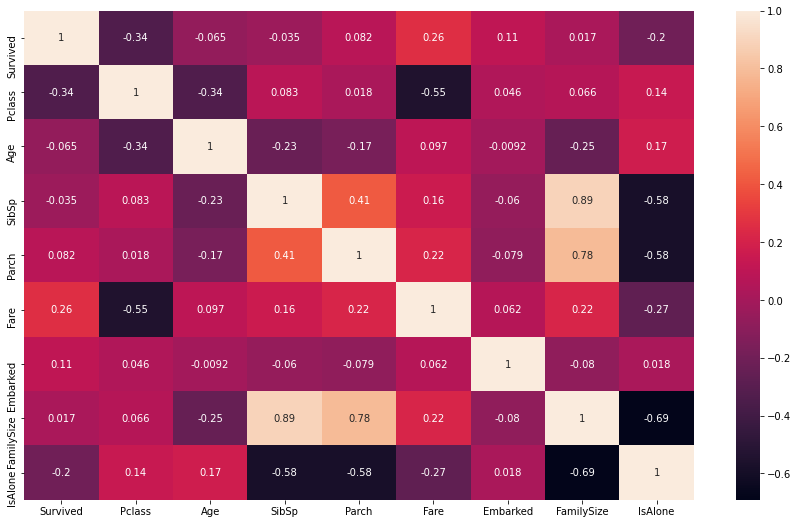

In [18]:
plt.figure(figsize = (15,9))
sns.heatmap(df.corr(), annot = True)

In [19]:
features = ['Pclass','Sex','Age','SibSp', 'Parch','Fare','Embarked', 'FamilySize', 'IsAlone']
X = pd.get_dummies(df[features])
y = df['Survived']

In [20]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Sex_female,Sex_male
0,3,22.0,1,0,7.2500,0,2,0,0,1
1,1,38.0,1,0,71.2833,1,2,0,1,0
2,3,26.0,0,0,7.9250,0,1,1,1,0
3,1,35.0,1,0,53.1000,0,2,0,1,0
4,3,35.0,0,0,8.0500,0,1,1,0,1


In [21]:
sc = StandardScaler()

In [22]:
feature_scale = ['Age','Fare']
X[feature_scale] = sc.fit_transform(X[feature_scale])

In [23]:
model_param = {
    'LogisticRegression':{
        'model' : LogisticRegression(solver = 'liblinear',multi_class = 'auto'),
        'param' : {
            'penalty': ('l1', 'l2'),
            'C':[0.01, 0.1, 1, 10]
        }
    },
    'DecisionTreeClassifier':{
        'model':DecisionTreeClassifier(),
        'param':{
            'criterion': ['gini','entropy'],
            'max_depth': [3, 4, 5]
        }
    },
    'KNeighborsClassifier':{
        'model': KNeighborsClassifier(),
        'param':{
            'n_neighbors':[5,10,15,20,25]
        }
    },
    'SVC':{
        'model': SVC(),
        'param': {
            'kernel':['rbf', 'linear','poly','sigmoid'],
            'C':[1,5,10,20,30,50,80,100]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'param' : {
            'n_estimators': [1000,1200,1500,2000,3000]
        }
    },
    'AdaBoostClassifier':{
        'model': ensemble.AdaBoostClassifier(),
        'param':{
            "n_estimators": [1, 10,100],
            'learning_rate':[.001,0.01,.1]
        }
    },
    'XGBClassifier':{
        'model' : XGBClassifier(),
        'param':{
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
        }
    },
    'lgb':{
        'model':lgb.LGBMClassifier(),
        'param':{'learning_rate': [0.01], 'n_estimators': [8, 24],
                   'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
                   'objective': ['binary'], 'seed': [500],
                   'colsample_bytree': [0.65, 0.75, 0.8], 
                   'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                   'reg_lambda': [1, 2, 6]
                 }
    }
}

In [24]:
import warnings
warnings.filterwarnings('ignore')

scores =[]
for model_name, mp in model_param.items():
    model_selection = GridSearchCV(estimator=mp['model'],param_grid=mp['param'],cv=5,return_train_score=False)
    model_selection.fit(X,y)
    scores.append({
        'model': model_name,
        'best_score': model_selection.best_score_,
        'best_params': model_selection.best_params_
    })

[00:28:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [25]:
df_model_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_model_score

,model,best_score,best_params
0,LogisticRegression,0.794614,"{'C': 1, 'penalty': 'l2'}"
1,DecisionTreeClassifier,0.772205,{'criterion': 'gini'}
2,KNeighborsClassifier,0.813697,{'n_neighbors': 20}
3,SVC,0.828278,"{'C': 5, 'kernel': 'rbf'}"
4,random_forest,0.811462,{'n_estimators': 2000}
5,AdaBoostClassifier,0.796905,"{'learning_rate': 0.1, 'n_estimators': 100}"
6,XGBClassifier,0.844015,"{'colsample_bytree': 1.0, 'gamma': 1, 'max_dep..."
7,lgb,0.644253,"{'boosting_type': 'gbdt', 'colsample_bytree': ..."


In [68]:
model_xgb = XGBClassifier(colsample_bytree= 1.0,gamma= 1,max_depth= 5,min_child_weight= 5,subsample= 0.8)

In [27]:
model_xgb.fit(X, y)

[00:31:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
df2 = pd.read_csv('/kaggle/input/titanic/test.csv')

In [29]:
df2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [30]:
df3=df2.drop(['PassengerId','Name','Ticket','Cabin'], axis=1 )

In [31]:
df3.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [32]:
df3.Embarked.fillna(df3['Embarked'].mode()[0],inplace=True)

In [33]:
df3['Embarked'] = df3['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [34]:
df3['FamilySize'] = df3['SibSp'] + df3['Parch'] + 1

In [35]:
df3['IsAlone'] = 0
df3.loc[df3['FamilySize'] == 1, 'IsAlone'] = 1

In [36]:
df3['Age'].fillna(df3['Age'].median(),inplace=True)
df3['Fare'].fillna(df3['Fare'].mean(),inplace=True)

In [37]:
features = ['Pclass','Sex','Age','SibSp', 'Parch','Fare','Embarked', 'FamilySize', 'IsAlone']
df3 = pd.get_dummies(df3[features])

In [38]:
df3.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Sex_female,Sex_male
0,3,34.5,0,0,7.8292,2,1,1,0,1
1,3,47.0,1,0,7.0000,0,2,0,1,0
2,2,62.0,0,0,9.6875,2,1,1,0,1
3,3,27.0,0,0,8.6625,0,1,1,0,1
4,3,22.0,1,1,12.2875,0,3,0,1,0


In [39]:
feature_scale = ['Age','Fare']
df3[feature_scale] = sc.fit_transform(df3[feature_scale])
# df3[feature_scale] = sc.fit_transform(df3[feature_scale])

In [40]:
df3.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Sex_female,Sex_male
0,3,0.394887,0,0,-0.490783,2,1,1,0,1
1,3,1.355510,1,0,-0.507479,0,2,0,1,0
2,2,2.508257,0,0,-0.453367,2,1,1,0,1
3,3,-0.181487,0,0,-0.474005,0,1,1,0,1
4,3,-0.565736,1,1,-0.401017,0,3,0,1,0


In [41]:
y_predicted = model_xgb.predict(df3)

In [42]:
submission = pd.DataFrame({
        "PassengerId": df2['PassengerId'],
        "Survived": y_predicted
    })

In [43]:
submission.to_csv('titanic_submission_v01.csv', index=False)